In [1]:
import pandas as pd
import numpy as np
import tabulate
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Retrieve the metrics generated from testing each of the classifiers.
adaboost = pd.read_csv('../metrics/ada-evaluation.csv')
xgboost = pd.read_csv('../metrics/xgb-evaluation.csv')
catboost = pd.read_csv('../metrics/catboost-evaluation.csv')
linearsvc = pd.read_csv('../metrics/linearSVC-evaluation.csv')
pytorch = pd.read_csv('../metrics/mlp-evaluation.csv')
extratrees = pd.read_csv('../metrics/extratrees-evaluation.csv')   
sgd = pd.read_csv('../metrics/sgd-evaluation.csv') 
stacking = pd.read_csv('../metrics/stacking-trees-evaluation.csv')
lightgbm = pd.read_csv('../metrics/LGBM-evaluation.csv')
lightgbm_pfam = pd.read_csv('../metrics/LGBM-P-evaluation.csv')             

In [3]:
print(xgboost.columns)

Index(['accuracy', 'precision', 'f1_score', 'micro_recall', 'macro_recall',
       'confusion_matrix'],
      dtype='object')


In [4]:
dataframes = [
    ('LGBM', lightgbm),
    ('LGBM-P', lightgbm_pfam),
    ('CTB', catboost),
    ('XGB', xgboost),
    ('ADB', adaboost),
    ('LSVC', linearsvc),
    ('SGD', sgd),
    ('EXT', extratrees),
    ('STACK', stacking),
    ('MLP', pytorch)
]

# I opted to omit the confusion matrix and also add a column that indicates which classifier the data came from.
for i, (name, df) in enumerate(dataframes):
    df['source'] = name
    if 'confusion_matrix' in df.columns:
        df = df.drop(columns=['confusion_matrix'])
    cols = ['source'] + [col for col in df if col != 'source']
    df = df[cols]
    df = df.round(3)
    dataframes[i] = (name, df)

# Merge all of the DataFrames and then save as CSV.
merged_df = pd.concat([df for name, df in dataframes], ignore_index=True)
print(merged_df.columns.tolist())
merged_df.to_csv('merged_data.csv', index=False)

['source', 'accuracy', 'precision', 'f1_score', 'micro_recall', 'macro_recall']


In [5]:
# Show which classifier was the best for each metric.
merged_df = pd.read_csv('merged_data.csv')
metrics = ['accuracy', 'precision', 'micro_recall', 'macro_recall', 'f1_score']

for metric in metrics:
    best_source = merged_df.loc[merged_df[metric].idxmax(), 'source']
    best_value = merged_df[metric].max()
    print(f"Highest {metric}: {best_source} ({best_value:.4f})")

Highest accuracy: XGB (0.8940)
Highest precision: XGB (0.8930)
Highest micro_recall: XGB (0.8940)
Highest macro_recall: LGBM (0.8160)
Highest f1_score: XGB (0.8900)


In [6]:
# Display rankings for each metric.
metrics = ['accuracy', 'precision', 'micro_recall', 'macro_recall', 'f1_score']

for metric in metrics:
    ranked = merged_df.sort_values(by=metric, ascending=False)[['source', metric]]
    print(f"\nRanked list for {metric}:")
    for index, row in ranked.iterrows():
        print(f"{row['source']}: {row[metric]:.4f}")
    print("\n" + "="*40)  


Ranked list for accuracy:
XGB: 0.8940
LGBM: 0.8690
LGBM-P: 0.8650
CTB: 0.8650
MLP: 0.8490
STACK: 0.8410
ADB: 0.8400
EXT: 0.8380
LSVC: 0.7720
SGD: 0.7400


Ranked list for precision:
XGB: 0.8930
LGBM: 0.8770
LGBM-P: 0.8730
CTB: 0.8610
LSVC: 0.8600
SGD: 0.8580
ADB: 0.8520
MLP: 0.8400
EXT: 0.8130
STACK: 0.7970


Ranked list for micro_recall:
XGB: 0.8940
LGBM: 0.8690
LGBM-P: 0.8650
CTB: 0.8650
MLP: 0.8490
STACK: 0.8410
ADB: 0.8400
EXT: 0.8380
LSVC: 0.7720
SGD: 0.7400


Ranked list for macro_recall:
LGBM: 0.8160
LGBM-P: 0.8130
SGD: 0.7680
XGB: 0.7560
LSVC: 0.7420
CTB: 0.7300
MLP: 0.6600
ADB: 0.5940
EXT: 0.5920
STACK: 0.5920


Ranked list for f1_score:
XGB: 0.8900
LGBM: 0.8720
LGBM-P: 0.8680
CTB: 0.8620
MLP: 0.8420
ADB: 0.8180
STACK: 0.8180
EXT: 0.8160
LSVC: 0.8050
SGD: 0.7790



In [7]:
# This first puts the rankings inside a dictionary, then exports to JSON.
file_name = 'rankings.json'
metrics = ['accuracy', 'precision', 'micro_recall', 'macro_recall', 'f1_score']
all_rankings = {}
for metric in metrics:
    ranked = merged_df.sort_values(by=metric, ascending=False)[['source', metric]]
    metric_rankings = [{'source': row['source'], metric: row[metric]} for _, row in ranked.iterrows()]
    all_rankings[metric] = metric_rankings
with open(f'../metrics/{file_name}', 'w') as json_file:
    json.dump(all_rankings, json_file, indent=4)

print(f'Exported to {file_name}')

Exported to rankings.json


### Plot the metrics for each classifier.

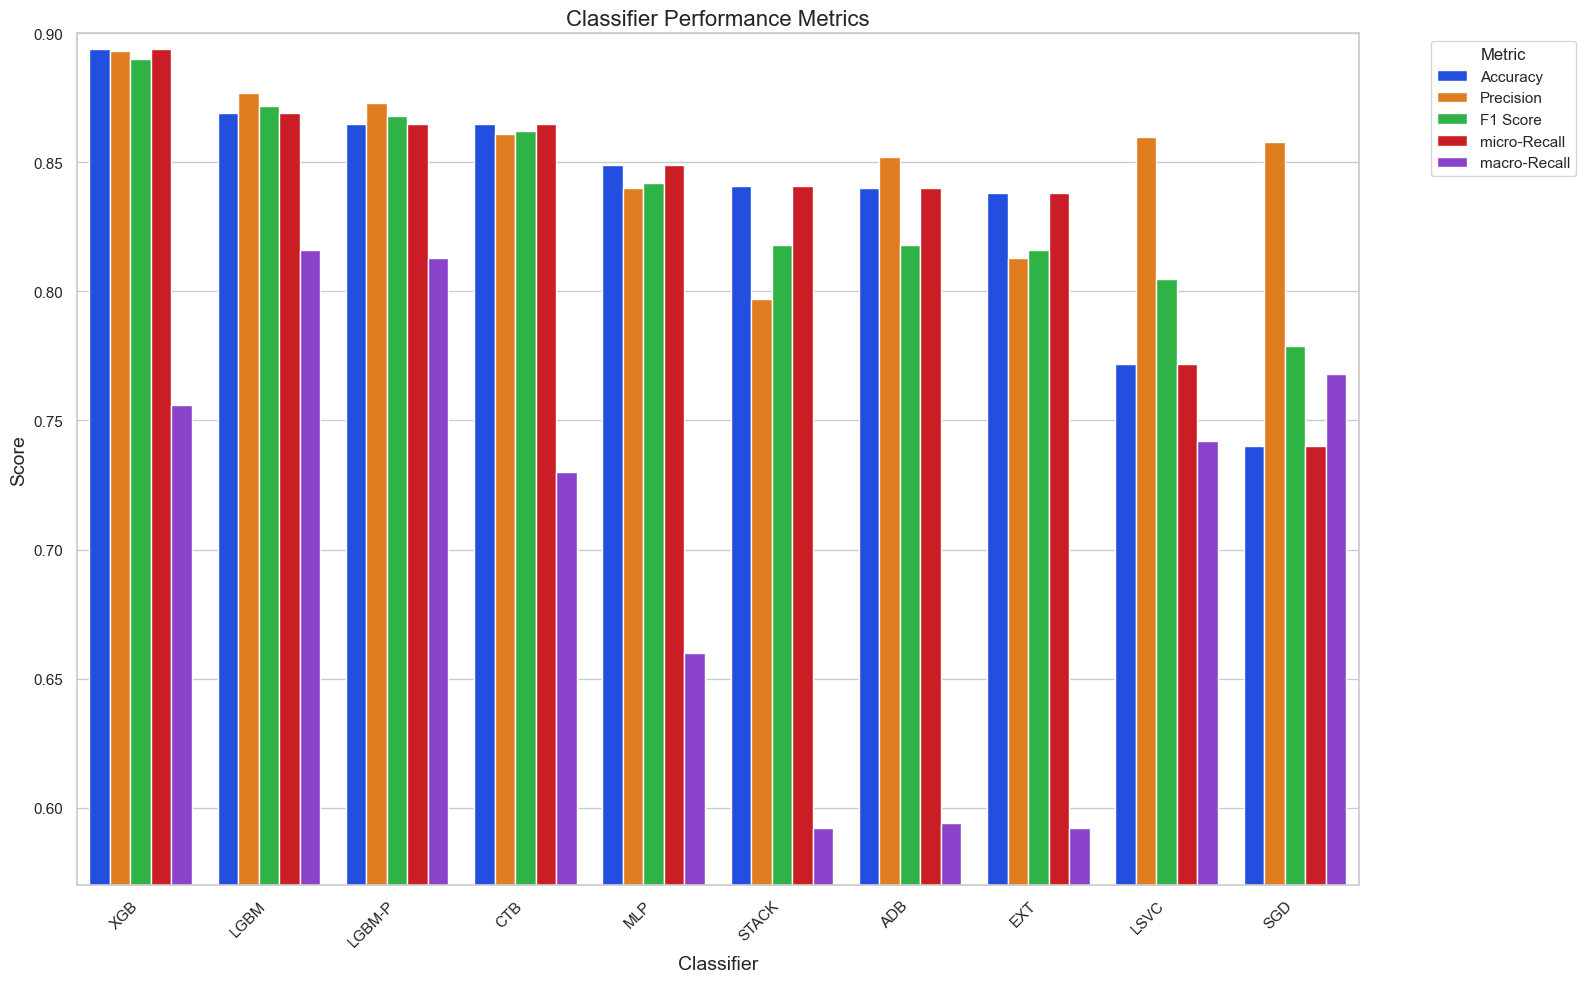

In [8]:
def prepare_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        
    processed_data = {
        'Classifier': [],
        'Accuracy': [],
        'Precision': [],
        'F1 Score': [],
        'micro-Recall': [],
        'macro-Recall': []
    }

    metric_map = {
        'accuracy': 'Accuracy',
        'precision': 'Precision',
        'f1_score': 'F1 Score',
        'micro_recall': 'micro-Recall',
        'macro_recall': 'macro-Recall'
    }

    for metric in ['accuracy', 'precision', 'f1_score', 'micro_recall', 'macro_recall']:
        for item in data[metric]:
            source = item['source']
            value = item[metric]
            if source not in processed_data['Classifier']:
                processed_data['Classifier'].append(source)
                for key in processed_data.keys():
                    if key != 'Classifier':
                        processed_data[key].append(None)
            index = processed_data['Classifier'].index(source)
            column_name = metric_map[metric]
            processed_data[column_name][index] = value
    return pd.DataFrame(processed_data)

def create_plot(df):
    plt.figure(figsize=(16, 10))
    sns.set(style='whitegrid')
    bar_plot = sns.barplot(data=df.melt(id_vars='Classifier', var_name='Metric', value_name='Score'), 
                           x='Classifier', y='Score', hue='Metric', palette='bright')
    plt.title('Classifier Performance Metrics', fontsize=16)
    plt.xlabel('Classifier', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.2)
    plt.ylim(0.57, 0.9)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

file_path = '../metrics/rankings.json'
df = prepare_data(file_path)
create_plot(df)